In [16]:
import pandas as pd
import glob
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
from sklearn.metrics import f1_score

In [17]:
plt.style.use('dark_background')

In [18]:
def cargar_csvs(carpeta):
    archivos = glob.glob(os.path.join(carpeta, '*.csv'))#Carga de los datos
    dataframes = [pd.read_csv(f) for f in archivos]
    return pd.concat(dataframes, ignore_index=True)

In [19]:
def convertir_a_vector(texto):
    # Elimina corchetes y convierte a float
    texto = texto.replace('[', '').replace(']', '').replace('\n', ' ')
    # Corta y filtra los strings
    cleaned_values = [x for x in texto.strip().split() if x and x != '...']
    # Valores validos a float
    if cleaned_values:
        return np.array([float(x) for x in cleaned_values])
    else:
        # Array vacio si no hay datos validos
        return np.array([])

In [20]:
carpeta = './datos'  #Carga de los datos
df = cargar_csvs(carpeta)
df['features'] = df['data'].apply(convertir_a_vector)
df = df[df['features'].apply(lambda x: x.size > 0)]# Remover filas con vectores vacíos si existen
Longitudes = df['features'].apply(len)
# Se asegura de que todos los vectores tengan la misma longitud, para poder pasarlso a la matriz
if not Longitudes.nunique() <= 1:
    raise ValueError("Vectores no uniformes.")

if Longitudes.empty or Longitudes.iloc[0] == 0:
    raise ValueError("No hay valores validos.")

Largo_vector = Longitudes.iloc[0]
X = np.stack(df['features'].values)
y_raw = df['predicted_class'].values
encoder = LabelEncoder()
y = encoder.fit_transform(y_raw)


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)




In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(Largo_vector,)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(len(encoder.classes_), activation='softmax')
    ])
model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
history = model.fit(X_train, y_train, epochs=100,validation_split=0.2)

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 181ms/step - accuracy: 0.2335 - loss: 2.2321 - val_accuracy: 0.7419 - val_loss: 1.0895
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5835 - loss: 1.3837 - val_accuracy: 0.7204 - val_loss: 0.8355
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7113 - loss: 0.9028 - val_accuracy: 0.7742 - val_loss: 0.7753
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7484 - loss: 0.8322 - val_accuracy: 0.7634 - val_loss: 0.7531
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7791 - loss: 0.6511 - val_accuracy: 0.7419 - val_loss: 0.7600
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7240 - loss: 0.8824 - val_accuracy: 0.7527 - val_loss: 0.7624
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7331 - loss: 0.8443 - val_accuracy: 0.7634 - val_loss: 0.7629
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7448 - loss: 0.7726 - val_accuracy: 0.7742 

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.7642 - loss: 0.9798

Precisión: 0.77


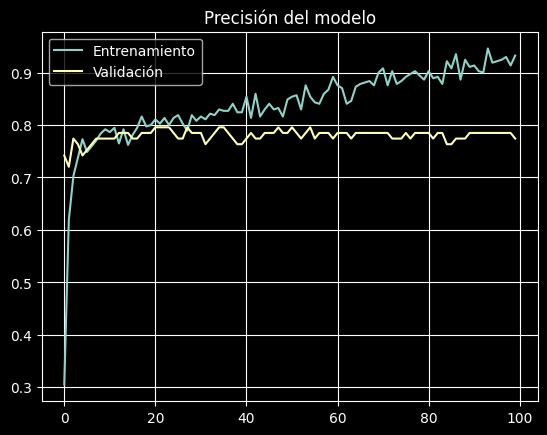

In [23]:
# Evaluación
loss, acc = model.evaluate(X_test, y_test)
print(f"\nPrecisión: {acc:.2f}")
plt.plot(history.history['accuracy'], label='Entrenamiento')#Vemos que tal los resultados del entrenamiento
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title("Precisión del modelo")
plt.legend()
plt.grid(True)
plt.show()

In [24]:
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1) # Obtener las clases predichas

# Calcular el f1 score
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"f1 score: {f1:.2f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
f1 score: 0.72


In [25]:
# Guardar modelo
model.save('modelo_alertas.keras')